# Zero-Inflated Model Using Tree Based Methods

The dataset used for this application will be the same NHANES dataset that has been used in previous applications. Here, the target variable is a depression score that has been computed based on surveys completed by participants. Zero-inflated models are employed for this dataset because it is expected (and observed) that most patients will not have depression and score low on the depression index (0). The model shall first classify the patient into the depression or non depression group. Once classified, if the patient belongs to the depression group, another model is required to determine the severity of the depression. In this worksheet, various tree based methods will be used to first classify patient into depressive and non-depressive categories, which will be adminstired using a cut-off threshold at scores of 1. Second, regression trees will be used to evaluate the severity of depression of patients classified as depressive. 

In [3]:
import os, pandas as pd, numpy as np
import matplotlib.pyplot as plt

master = pd.read_csv(os.path.dirname(os.path.dirname(os.getcwd()))+"/Data/NHANES/master_depression.csv").set_index("SEQN")

In [4]:
master.dropna(inplace=True)

In our last analysis of the NHANES dataset, it was observed that there is high multicollinearity among some variables. These variables will be removed.

In [5]:
master.drop(columns=['LBXBCD', 'LBXWBCSI', 'LBXBCD', 'LBXRBCSI', "LBXWBCSI", 'LBXBCD', 'LBXRBCSI', 'LBXWBCSI', 'LBXBCD'], inplace=True)

In [6]:
from sklearn.model_selection import train_test_split
X = master.drop(columns="DepressionScore")
y = master["DepressionScore"]
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7, random_state=4)
X_train2, X_test, y_train2, y_test = train_test_split(X_train, y_train, train_size=0.7, random_state=4)

In [7]:
# create binary y's for zero classification

y_train_bin = y_train > 1
y_train2_bin = y_train2 > 1
y_test_bin = y_test > 1
y_val_bin = y_val > 1

## Classification of Zeros

### Classification Tree

In [8]:
from sklearn.tree import DecisionTreeClassifier

classification_model1 = DecisionTreeClassifier()
classification_model1.fit(X_train2, y_train2_bin)

DecisionTreeClassifier()

Testing ROC AUC 0.4692581435089759


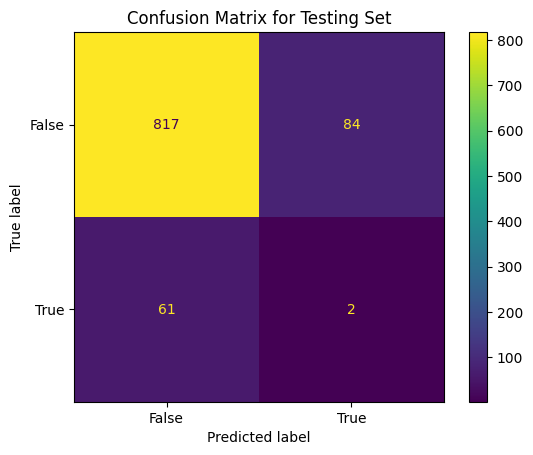

In [9]:
pred = classification_model1.predict(X_test)
val = y_test_bin

# Create a confusion matrix of our results
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import roc_auc_score

print("Testing ROC AUC", roc_auc_score(val, pred))
cm1 = ConfusionMatrixDisplay.from_predictions(val, pred)
cm1.ax_.set_title("Confusion Matrix for Testing Set")
plt.show()

Our decision tree classifier performs very poorly, in fact it would have been more accurate to predict everything as false. Two explainations of this poor performance are that the classifier is overfitting to the training data or the model is not complex enough to determine the underlying structure of the data. The latter can be solved using more advanced methods such as bagging or random forests. First, the focus will be to determine if our model is overfitting on the training set. Let's create a confusion matrix for our training data

Training ROC AUC 1.0


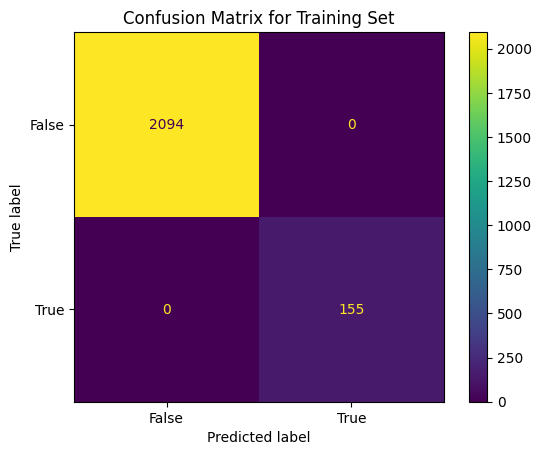

In [10]:
pred = classification_model1.predict(X_train2)
val = y_train2_bin

print("Training ROC AUC", roc_auc_score(val, pred))
cm1 = ConfusionMatrixDisplay.from_predictions(val, pred)
cm1.ax_.set_title("Confusion Matrix for Training Set")
plt.show()

Observe from the confusion matrix from the training set that the model is indeed overfitting. There are several hyperparameters that can be tuned to reduce the overfitting such as the maximum depth of the tree, the minimum number of samples required to split a node, or the minimum number of samples required to be a leaf node.

#### Hyperparameter Tuning

In [11]:
# tune tree depth
from sklearn.model_selection import cross_val_score

depths = range(1,20)
score = []
for i in depths:
    clf = DecisionTreeClassifier(max_depth=i)
    scores = cross_val_score(clf, X_train, y_train_bin, cv=5, scoring = "roc_auc")
    score.append(np.mean(scores))


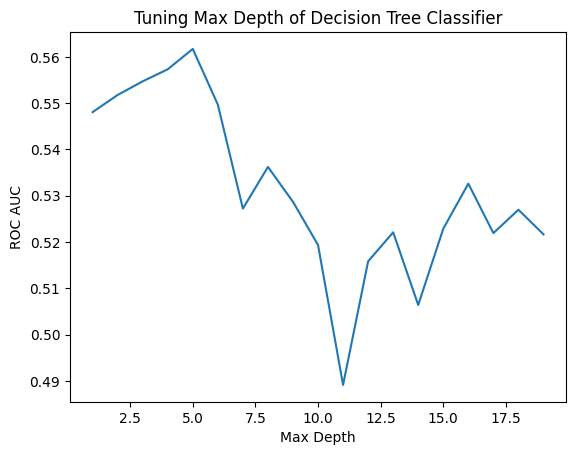

In [12]:
plt.plot(depths, score)
plt.title("Tuning Max Depth of Decision Tree Classifier")
plt.xlabel("Max Depth")
plt.ylabel("ROC AUC")
plt.show()

It appears that there is no strong trend between the depth of the tree and its roc auc. Let's try to observe this trend in the training and testing data

In [13]:
train_score = []
test_score = []
for i in depths:
    clf = DecisionTreeClassifier(max_depth=i)
    clf.fit(X_train2, y_train2_bin)
    train_score.append(roc_auc_score(y_train2_bin, clf.predict(X_train2)))
    test_score.append(roc_auc_score(y_test_bin, clf.predict(X_test)))

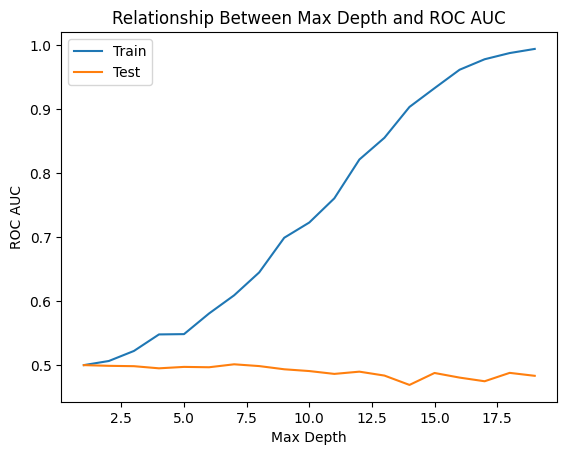

In [14]:
plt.plot(depths, train_score, label = "Train")
plt.plot(depths, test_score, label = "Test")
plt.legend()
plt.title("Relationship Between Max Depth and ROC AUC")
plt.xlabel("Max Depth")
plt.ylabel("ROC AUC")
plt.show()

The ROC AUC from both visualization appears close to 0.5 which shows how poorly our model is performing even after we are preventing overfitting. Let's try to tune the minimum number of samples and see if we get a better result

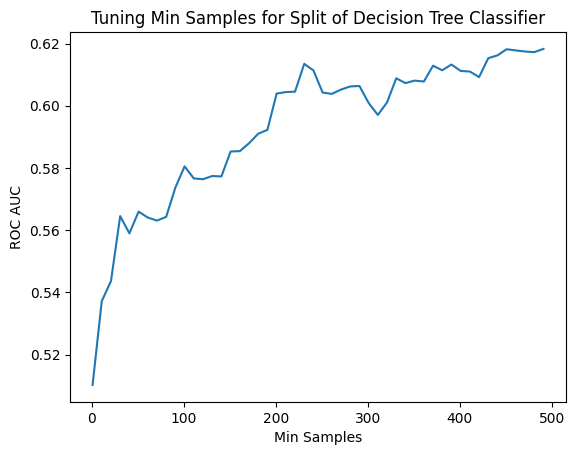

In [15]:
# tune node split criteria
values = range(1,500,10)
score = []
for i in values:
    clf = DecisionTreeClassifier(min_samples_split=i)
    scores = cross_val_score(clf, X_train, y_train_bin, cv=5, scoring = "roc_auc")
    score.append(np.mean(scores))

plt.plot(values, score)
plt.title("Tuning Min Samples for Split of Decision Tree Classifier")
plt.xlabel("Min Samples")
plt.ylabel("ROC AUC")
plt.show()

This time we see a weird pattern. The accuracy appears to increase as the complexity of the decision tree decreases. Let's see if this occurs also in the train data

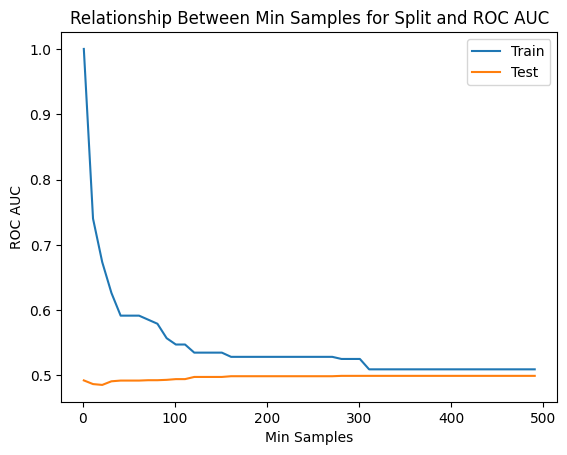

In [16]:
train_score = []
test_score = []
for i in values:
    clf = DecisionTreeClassifier(min_samples_split=i)
    clf.fit(X_train2, y_train2_bin)
    train_score.append(roc_auc_score(y_train2_bin, clf.predict(X_train2)))
    test_score.append(roc_auc_score(y_test_bin, clf.predict(X_test)))

plt.plot(values, train_score, label = "Train")
plt.plot(values, test_score, label = "Test")
plt.legend()
plt.title("Relationship Between Min Samples for Split and ROC AUC")
plt.xlabel("Min Samples")
plt.ylabel("ROC AUC")
plt.show()

We see the same results when comparing the train and test ROC AUCs. We are unable to reduce overfitting by restricting the minimum number of samples required for a split. But from our cross validation we see very interesting reduce. As the number of samples required for a split we actually see the CV ROC AUC increase which is very strange. And even with the increase in AUC, it is not significant enough to the point where we could confidently use the model in practice

Let's fit a final decision with 500 samples required for a split and compared it to a random forest classifier

Training ROC AUC 0.5158881009633793


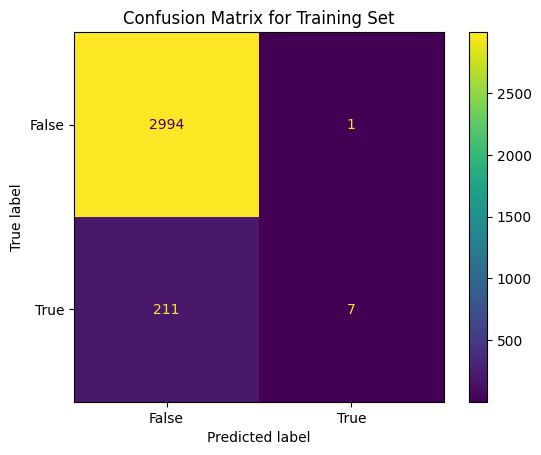

Validation ROC AUC 0.4984447900466563


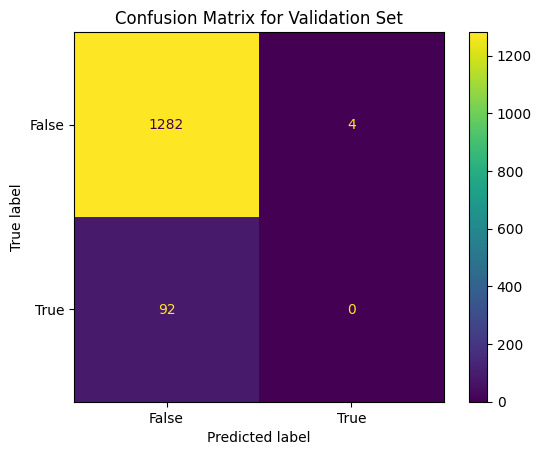

In [21]:
final_dtc = DecisionTreeClassifier(min_samples_split=500)
final_dtc.fit(X_train,y_train_bin)

pred = final_dtc.predict(X_train)
val = y_train_bin

print("Training ROC AUC", roc_auc_score(val, pred))
cm1 = ConfusionMatrixDisplay.from_predictions(val, pred)
cm1.ax_.set_title("Confusion Matrix for Training Set")
plt.show()

pred = final_dtc.predict(X_val)
val = y_val_bin

print("Validation ROC AUC", roc_auc_score(val, pred))
cm1 = ConfusionMatrixDisplay.from_predictions(val, pred)
cm1.ax_.set_title("Confusion Matrix for Validation Set")
plt.show()

Interestingly, the high ROC AUC from our cross validation does not translate the training and validation. Also note from the confusion matrix, we would be more accurate if we classified all patients as non-depressive. Further, the predictions we make about depressed patients are all incorrect.

### Random Forest Classifier

Training ROC AUC 0.9967741935483871


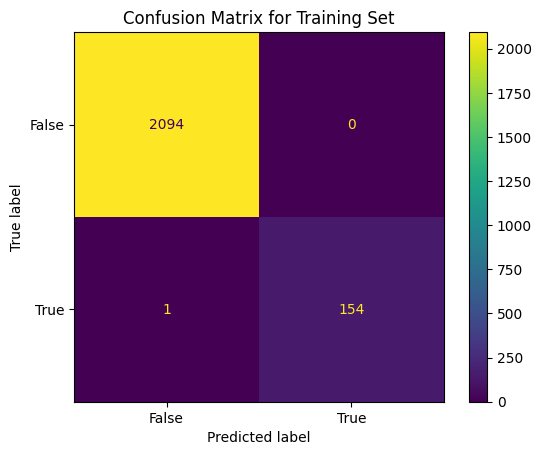

Testing ROC AUC 0.5


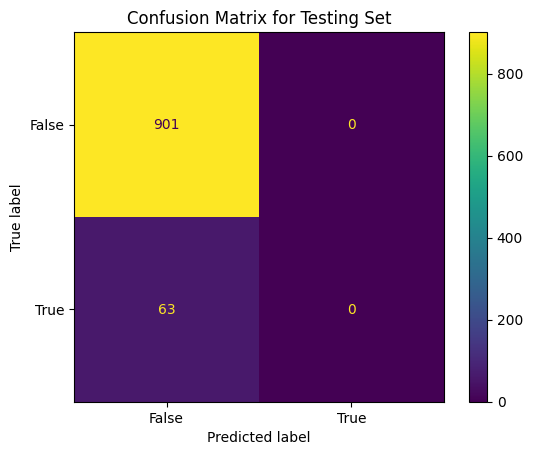

In [18]:
from sklearn.ensemble import RandomForestClassifier

classification_model2 = RandomForestClassifier()
classification_model2.fit(X_train2, y_train2_bin)

print("Training ROC AUC", roc_auc_score(y_train2_bin, classification_model2.predict(X_train2)))
cm1 = ConfusionMatrixDisplay.from_predictions(y_train2_bin, classification_model2.predict(X_train2))
cm1.ax_.set_title("Confusion Matrix for Training Set")
plt.show()

print("Testing ROC AUC", roc_auc_score(y_test_bin, classification_model2.predict(X_test)))
cm1 = ConfusionMatrixDisplay.from_predictions(y_test_bin, classification_model2.predict(X_test))
cm1.ax_.set_title("Confusion Matrix for Testing Set")
plt.show()

The random forest classifier results in an increase in test accuracy but only because this model classifies all observations as false. In fact there is an drop in the AUC.

#### Hyperparameter Tuning

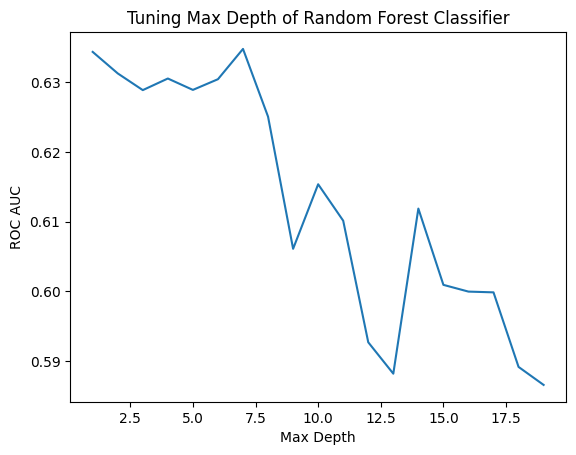

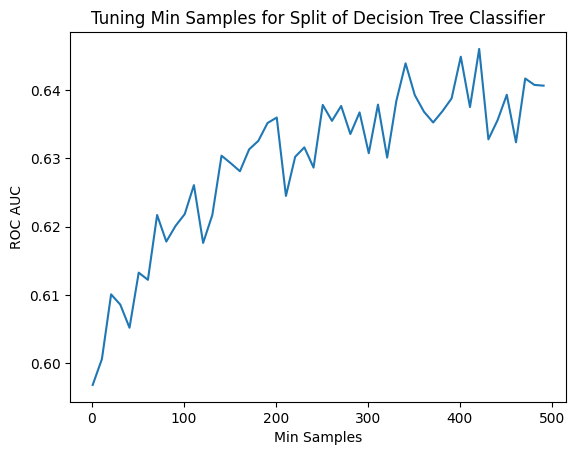

In [20]:
# tune tree depth
depths = range(1,20)
score = []
for i in depths:
    clf = RandomForestClassifier(max_depth=i)
    scores = cross_val_score(clf, X_train, y_train_bin, cv=5,scoring = "roc_auc")
    score.append(np.mean(scores))

plt.plot(depths, score)
plt.title("Tuning Max Depth of Random Forest Classifier")
plt.xlabel("Max Depth")
plt.ylabel("ROC AUC")
plt.show()

# tune node split criteria
values = range(1,500,10)
score = []
for i in values:
    clf = RandomForestClassifier(min_samples_split=i)
    scores = cross_val_score(clf, X_train, y_train_bin, cv=5, scoring = "roc_auc")
    score.append(np.mean(scores))

plt.plot(values, score)
plt.title("Tuning Min Samples for Split of Decision Tree Classifier")
plt.xlabel("Min Samples")
plt.ylabel("ROC AUC")
plt.show()

We see a spike in the ROC AUC for max depth of roughly 7 and the min samples for a split of 400. 

Training ROC AUC 0.5


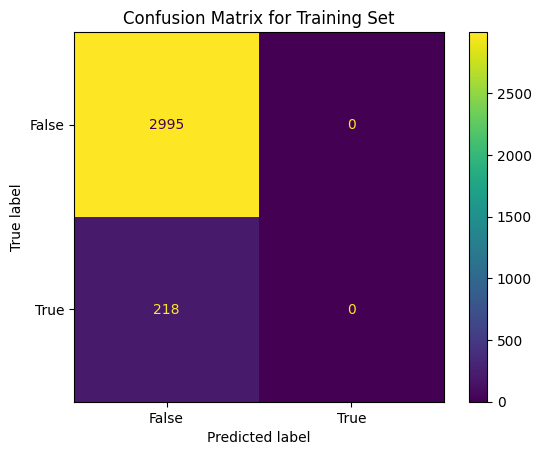

Validation ROC AUC 0.5


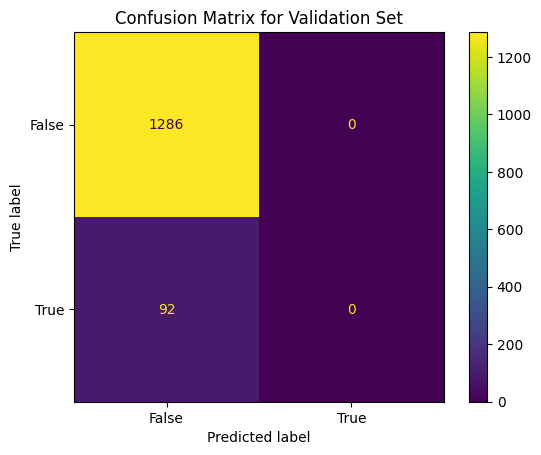

In [22]:
final_rfc = RandomForestClassifier(max_depth=7, min_samples_split=400)
final_rfc.fit(X_train,y_train_bin)

pred = final_rfc.predict(X_train)
val = y_train_bin

print("Training ROC AUC", roc_auc_score(val, pred))
cm1 = ConfusionMatrixDisplay.from_predictions(val, pred)
cm1.ax_.set_title("Confusion Matrix for Training Set")
plt.show()

pred = final_rfc.predict(X_val)
val = y_val_bin

print("Validation ROC AUC", roc_auc_score(val, pred))
cm1 = ConfusionMatrixDisplay.from_predictions(val, pred)
cm1.ax_.set_title("Confusion Matrix for Validation Set")
plt.show()


The random forest classifier predicts all patients as non depressive for a poor 0.5 ROC AUC. 

## Conclusion

Ultimately, none of the models built are viable for the clinical setting they unable to make any accurate predictions on patient's depression.

Also, it is no possible to go further and complete our zero-inflated model when the classification model classifies each observation as 0.

For the next application it may be beneficial to mine more input variables from the collection of datasets in NHANES
